In [ ]:
# %load C:/Users/Saisandeep/Documents/Udacity Data Analyst/Machine-Learning/ud120-projects/final_project/tester.py
#!/usr/bin/pickle

""" a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


Number of features:  18
Total no. of employees in dataset: 146
Total no. of POI in dataset: 18


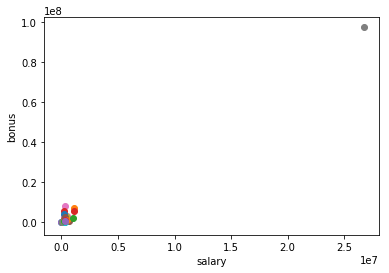

In [37]:
# %load C:/Users/Saisandeep/Documents/Udacity Data Analyst/Machine-Learning/ud120-projects/final_project/poi_id.py
#!/usr/bin/python

import sys
import pickle
sys.path.append("C:/Users/Saisandeep/Documents/Udacity Data Analyst/Machine-Learning/ud120-projects/tools/")
sys.path.append("C:/Users/Saisandeep/Documents/Udacity Data Analyst/Machine-Learning/ud120-projects/final_project/")
import random
import matplotlib.pyplot as plt
from time import time
import numpy as np

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pprint
import json

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
                 'expenses', 'exercised_stock_options', 'long_term_incentive',
                 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person',
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
# You will need to use more features

print 'Number of features: ', len(features_list)-1

### Load the dictionary containing the dataset
with open("C:/Users/Saisandeep/Documents/Udacity Data Analyst/Machine-Learning/ud120-projects/final_project\
/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

#explore dataset

#num = 0
#for i in data_dict:
#    num = num+1
#    if num<3:
#        print json.dumps(data_dict[i], indent=1)

num_of_emp = len(data_dict)
print 'Total no. of employees in dataset:', num_of_emp

num_of_poi = 0
for i in data_dict:
    if data_dict[i]['poi']==True:
        num_of_poi += 1

print 'Total no. of POI in dataset:', num_of_poi


features =['salary', 'bonus']
data = featureFormat(data_dict, features)
for point in data:
    salary=point[0]
    bonus=point[1]
    plt.scatter(salary, bonus)
plt.xlabel('salary')
plt.ylabel('bonus')

plt.show() # There is an outlier

for i, v in data_dict.items():
    if v['salary'] != 'NaN' and v['salary'] > 10000000:
        print i

data_dict.pop('TOTAL', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0 )
data_dict.pop('LOCKHART EUGENE E', 0)



### Task 2: Remove outliers
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

In [ ]:
import sys
import pickle
sys.path.append("C:/Users/Saisandeep/Documents/Udacity Data Analyst/Machine-Learning/ud120-projects/tools/")
sys.path.append("C:/Users/Saisandeep/Documents/Udacity Data Analyst/Machine-Learning/ud120-projects/final_project/")
import matplotlib.pyplot as plt
from time import time
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pprint
import json

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data


### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

all_features = ['poi', 'email_address', 'salary', 'to_messages', 'deferral_payments', 'total_payments', \
                'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', \
                'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', \
                'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', \
                'from_poi_to_this_person']

fin_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', \
                'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', \
                'long_term_incentive', 'restricted_stock', 'director_fees']

email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', \
                  'shared_receipt_with_poi']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)


df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN', np.nan)

### Task 2: Remove outliers and deal with missing values

df[financial_features] = df[financial_features].fillna(0)
df[email_features] = df[email_features].fillna(df[email_features].median())

# outliers
df = df.drop('TOTAL')
df = df[df.from_messages < 6000]
df = df[df.to_messages < 10000]

### Task 3: Create new feature(s)
df['ratio_of_messages_to_poi'] = df.from_this_person_to_poi / df.from_messages
df['ratio_of_messages_from_poi'] = df.from_poi_to_this_person / df.to_messages


my_dataset = df.to_dict('index')

features_list = [u'poi', u'salary', u'to_messages', u'deferral_payments', u'total_payments',
       u'exercised_stock_options', u'bonus', u'restricted_stock',
       u'shared_receipt_with_poi', u'expenses', u'from_messages', u'other',
       u'long_term_incentive', u'fracion_of_messages_to_poi',
       u'fracion_of_messages_from_poi']


### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, make_scorer
from sklearn.cross_validation import StratifiedKFold

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html


# grid = {
#     'base_estimator__criterion': ('gini', 'entropy'),
#     'base_estimator__min_samples_leaf':range(1, 50, 5),
#     'base_estimator__max_depth': range(1, 10),
#     'n_estimators': range(1,10)
# }

# search = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), 
#                       grid, make_scorer(f1_score), cv=StratifiedKFold(labels), n_jobs=-1)

# search.fit(features, labels)

# print search.best_score_
# print search.best_params_

# clf = search.best_estimator_


### To speed up the process of training the grid search is not included and the best parameters used.
### This is as recommended by the reviewer
best_params = {
	'n_estimators': 4, 
	'base_estimator__criterion': 'gini', 
	'base_estimator__max_depth': 3, 
	'base_estimator__min_samples_leaf': 11}

clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42)
clf.set_params(**best_params)


## Task 6: Dump your classifier, dataset, and features_list so anyone can
## check your results. You do not need to change anything below, but make sure
## that the version of poi_id.py that you submit can be run on its own and
## generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)